In [1]:
import netwulf as nw
import networkx as nx
import urllib.request
import json
import pandas as pd
import re
import pickle
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
from nltk.corpus import PlaintextCorpusReader
import urllib.parse
from nltk import word_tokenize
import nltk, re, pprint
import matplotlib_inline
%matplotlib inline
import pickle
from wordcloud import WordCloud
from collections import Counter
import community.community_louvain as community
import math
import powerlaw
import collections
import scipy
import squarify
import seaborn as sb
from nltk.corpus import stopwords
import matplotlib.patches as mpatches
nltk.download("stopwords")
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luxonice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
with open('LargeData/data2022.pkl', 'rb') as f:
    data = pickle.load(f)

# rename columns
data = data.rename(columns={'out_going':'author','in_going':'adressee'})

### Make Graph smaller

In [3]:
# Load graph from a pickle file
with open("LargeData/Directed2022.pkl", "rb") as file:
    G = pickle.load(file)

# Make GCC
UnG = G.to_undirected()
GCC = nx.subgraph(G,max(nx.weakly_connected_components(G), key=len))

G = nx.subgraph(G, [node for node in GCC.nodes()][:1000])

# Basic statistics

In [4]:
print('Number of nodes: ',G.number_of_nodes())
print('Number of edges: ',G.number_of_edges())

Number of nodes:  1000
Number of edges:  23714


In [5]:
print('Number of multiedges: ',len([x for x in G.edges() if G.number_of_edges(x[0],x[1]) > 1]))

Number of multiedges:  14710


Text(0, 0.5, 'Counts')

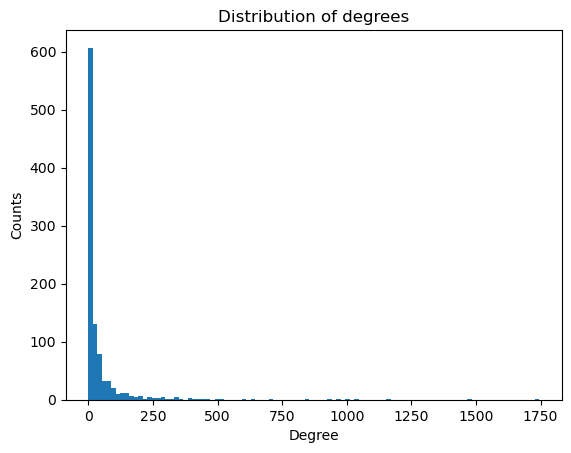

In [6]:
degree_sequence = [d for n, d in G.degree()]
plt.figure()
plt.hist(degree_sequence,bins=100)
plt.title('Distribution of degrees')
plt.xlabel('Degree')
plt.ylabel('Counts')

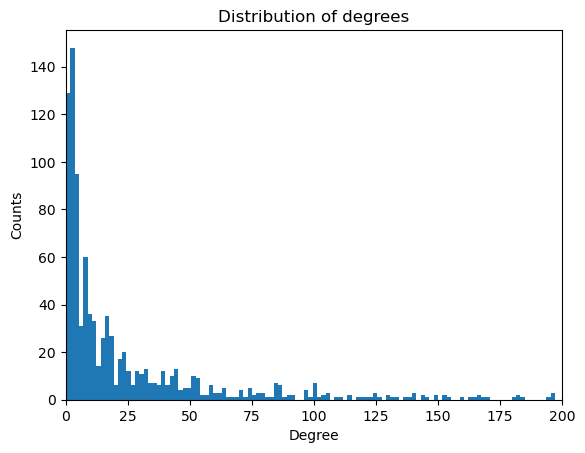

In [7]:
# Plot degree distribution with less tahn 1000 degrees
plt.figure()
plt.hist(degree_sequence,bins=1000)
plt.title('Distribution of degrees')
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.xlim(0,200)
plt.show()

In [8]:
# Find node with highest degree
max_degree = 0
max_degree_node = None
for node in G.nodes():
    if G.degree(node) > max_degree:
        max_degree = G.degree(node)
        max_degree_node = node

print('Node with highest degree: ',max_degree_node,' with degree: ',max_degree)

Node with highest degree:  mirrorconspiracies  with degree:  1745


In [9]:
# Print flair of node with highest degree
print('Flair of node with highest degree: ',G.nodes[max_degree_node]['flair'])

Flair of node with highest degree:  entp


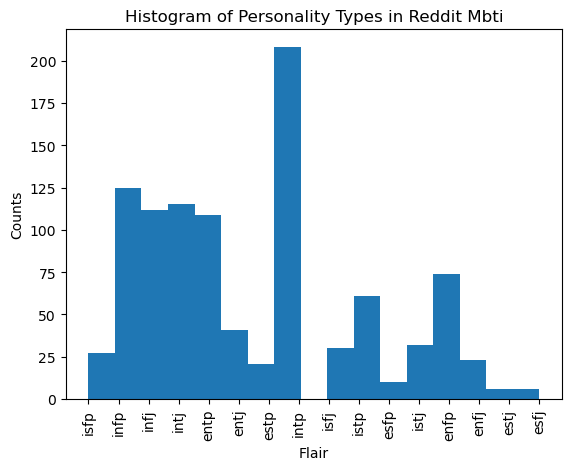

In [10]:
# Distribution of flair
flairs = [G.nodes[node]['flair'] for node in G.nodes()]
plt.figure()
plt.hist(flairs,bins=17)
plt.title('Histogram of Personality Types in Reddit Mbti')
plt.xlabel('Flair')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.show()

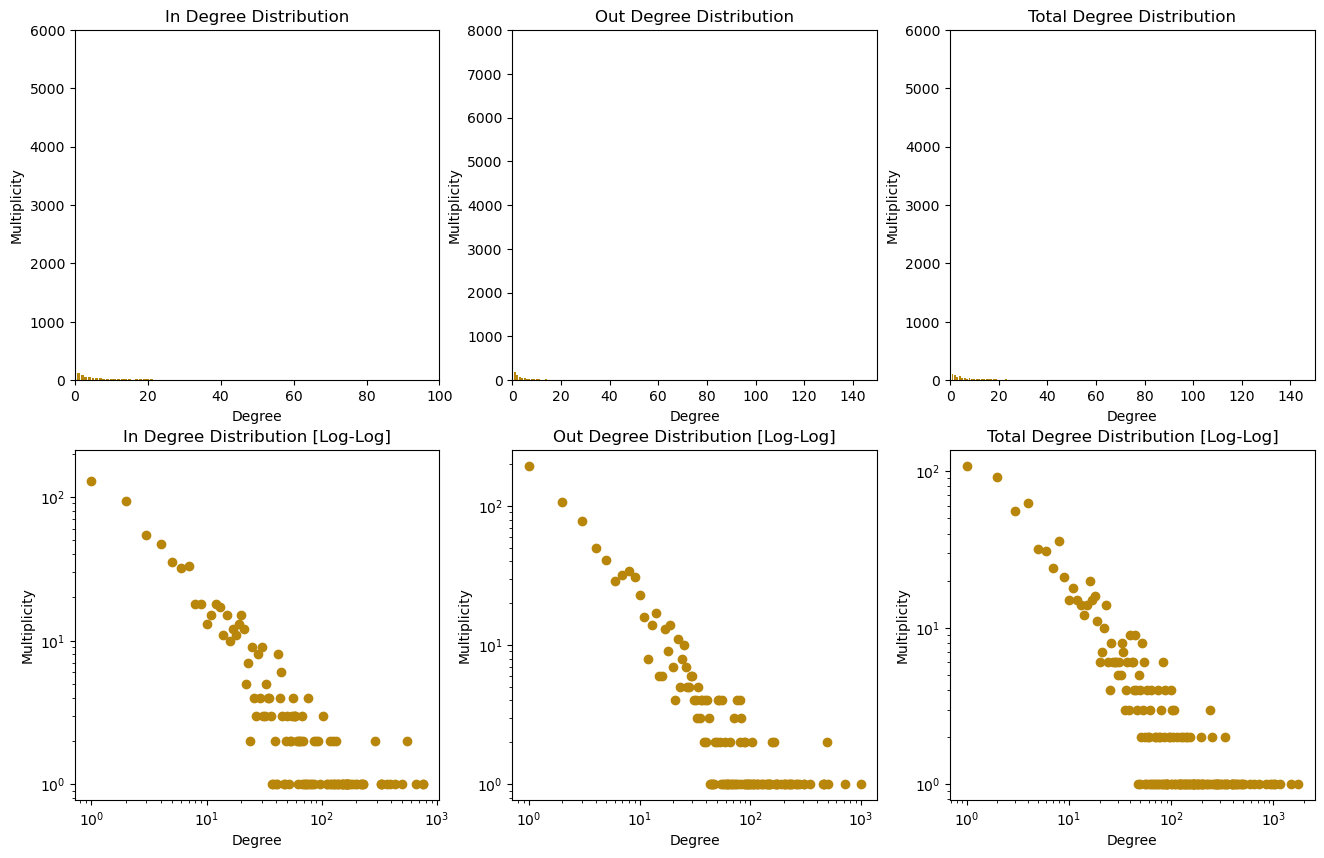

In [12]:
#Plot degree distribution of the Rapper graph
fig,ax = plt.subplots(2,3,figsize=(16,10))

in_degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)  # degree sequence
in_degreeCount = collections.Counter(in_degree_sequence)

ax[0,0].bar(in_degreeCount.keys(), in_degreeCount.values(), color='darkgoldenrod')
ax[0,0].set_title("In Degree Distribution")
ax[0,0].set_ylabel("Multiplicity")
ax[0,0].set_xlabel("Degree")
ax[0,0].set_xlim(0,100)
ax[0,0].set_ylim(0,6000)
ax[1,0].loglog(in_degreeCount.keys(), in_degreeCount.values(), color='darkgoldenrod',marker="o",linestyle="None")
ax[1,0].set_title("In Degree Distribution [Log-Log]")
ax[1,0].set_ylabel("Multiplicity")
ax[1,0].set_xlabel("Degree")

out_degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)  # degree sequence
out_degreeCount = collections.Counter(out_degree_sequence)

ax[0,1].bar(out_degreeCount.keys(), out_degreeCount.values(), color='darkgoldenrod')
ax[0,1].set_title("Out Degree Distribution")
ax[0,1].set_ylabel("Multiplicity")
ax[0,1].set_xlabel("Degree")
ax[0,1].set_xlim(0,150)
ax[0,1].set_ylim(0,8000)
ax[1,1].loglog(out_degreeCount.keys(), out_degreeCount.values(), color='darkgoldenrod',marker="o",linestyle="None")
ax[1,1].set_title("Out Degree Distribution [Log-Log]")
ax[1,1].set_ylabel("Multiplicity")
ax[1,1].set_xlabel("Degree")

degree_distribution = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount=collections.Counter(degree_distribution)

ax[0,2].bar(degreeCount.keys(), degreeCount.values(), color='darkgoldenrod')
ax[0,2].set_title("Total Degree Distribution")
ax[0,2].set_ylabel("Multiplicity")
ax[0,2].set_xlabel("Degree")
ax[0,2].set_xlim(0,150)
ax[0,2].set_ylim(0,6000)
ax[1,2].loglog(degreeCount.keys(), degreeCount.values(), color='darkgoldenrod',marker="o",linestyle="None")
ax[1,2].set_title("Total Degree Distribution [Log-Log]")
ax[1,2].set_ylabel("Multiplicity")
ax[1,2].set_xlabel("Degree")

plt.show()

In [14]:
in_degree_sequence = np.array(in_degree_sequence)
in_degree_sequence = in_degree_sequence[in_degree_sequence!=0]
results=powerlaw.Fit(in_degree_sequence)
print(f"The exponent for in-degree is: {results.power_law.alpha}")

The exponent for in-degree is: 2.1790315826939612


Calculating best minimal value for power law fit


In [15]:
out_degree_sequence = np.array(out_degree_sequence)
out_degree_sequence = out_degree_sequence[out_degree_sequence!=0]
out_degree_sequence = out_degree_sequence[out_degree_sequence!=np.nan]

results=powerlaw.Fit(out_degree_sequence)
print(f"The exponent for out-degree is: {results.power_law.alpha}")

The exponent for out-degree is: 1.9761576509357162


Calculating best minimal value for power law fit


In [16]:
#Compare to random graph
N=len(G.nodes)
p=2*len(G.edges)/(N*(N-1))

random_graph=nx.erdos_renyi_graph(N,p,directed=False,seed=42)
degree_sequence = sorted([d for n, d in random_graph.degree()], reverse=True)  # degree sequence
degree_sequence = np.array(degree_sequence)
degree_sequence = degree_sequence[degree_sequence!=0]
degreeCount = collections.Counter(in_degree_sequence)
results=powerlaw.Fit(degree_sequence)
print(f"The exponent for a ranom graph is {results.power_law.alpha}")

The exponent for a ranom graph is 26.61047428888179


Calculating best minimal value for power law fit


In [17]:
nw.visualize(GCC)

(None, None)

# WordCloud

Divide comments after authors flair and save in a file

In [18]:
if not os.path.exists('Flairs'):
    os.makedirs('Flairs')

# Create a txt file with all comments for each flair
for user in G.nodes():
    flair = G.nodes[user]['flair']
    
    # Create txt file for each flair
    if not os.path.exists('Flairs/' + flair + '.txt'):
        # create txt file
        f = open('Flairs/' + flair + '.txt', 'w')
        f.close()
    
    f = open('Flairs/' + flair + '.txt', 'a')
    f.write(G.nodes[user]['comments'] + '\n')
    f.close()


Define preprocessing of text and TermFrequency

In [29]:
# Remove the punctuation, set all lowercase, lemmatize and remove stopwords
def preprocess(text):
    text = re.sub(r'\'s','',text)
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower()
    text = word_tokenize(text)
    text = [t for t in text if t not in nltk.corpus.stopwords.words('english')]
    text = [nltk.WordNetLemmatizer().lemmatize(t) for t in text]
    return text

def TermFrequency(text):
    # Count the occurences of each word
    frequency = nltk.FreqDist(text)
    # Create list of words and occurences
    worddict = dict()
    for key,value in frequency.items():
        worddict[key] = value
    return worddict

Preprocess text - takes approx 1h for full 2022 graph

In [21]:
tmp = []
flair_list = []
for flair in os.listdir('Flairs'):
    tmp.append(preprocess(open('Flairs/' + flair).read()))
    flair_list.append(flair[:-4])


If final version save graph as this takes the longest

In [75]:
# save tmp pickle
#with open('LargeData/tmp.pickle', 'wb') as f:
#    pickle.dump(tmp, f)

define function to combine all texts

In [25]:
def combine_lists(list_of_lists):
    combined_list = []
    for l in range(len(list_of_lists)):
        combined_list.extend(list_of_lists[l])
    return combined_list

combine all texts

In [26]:
all = combine_lists(tmp)

define function to remove items from the list

In [27]:
def remove_list(list_,all_lists):
    for l in list_:
        all_lists.remove(l)
    return all_lists

Compute TFTR

In [38]:
data_for_wordcloud = []
c = 20
for i in range(len(tmp)):
    print(i)
    TFTR = []
    dict1 = TermFrequency(tmp[i])
    copy_all = all.copy()
    dict2 = TermFrequency(remove_list(tmp[i],copy_all))
    for key in dict1:
        word = key
        freq1 = dict1[key]
        if word in dict2:
            freq2 = dict2[word]
            TFTR.append([key,freq1**2/(freq2+c)])
    data_for_wordcloud.append(TFTR)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [39]:
# save data_for_wordcloud as pkl
with open('LargeData/data_for_wordcloud.pickle', 'wb') as f:
    pickle.dump(data_for_wordcloud, f)

In [40]:
def TFTR_to_string(TFTR):
    TFTR_string = ''
    for token in TFTR:
        TFTR_string += (token[0] + ' ') * int(token[1])
    return TFTR_string

for i in range(len(data_for_wordcloud)):
    data_for_wordcloud[i] = TFTR_to_string(data_for_wordcloud[i])

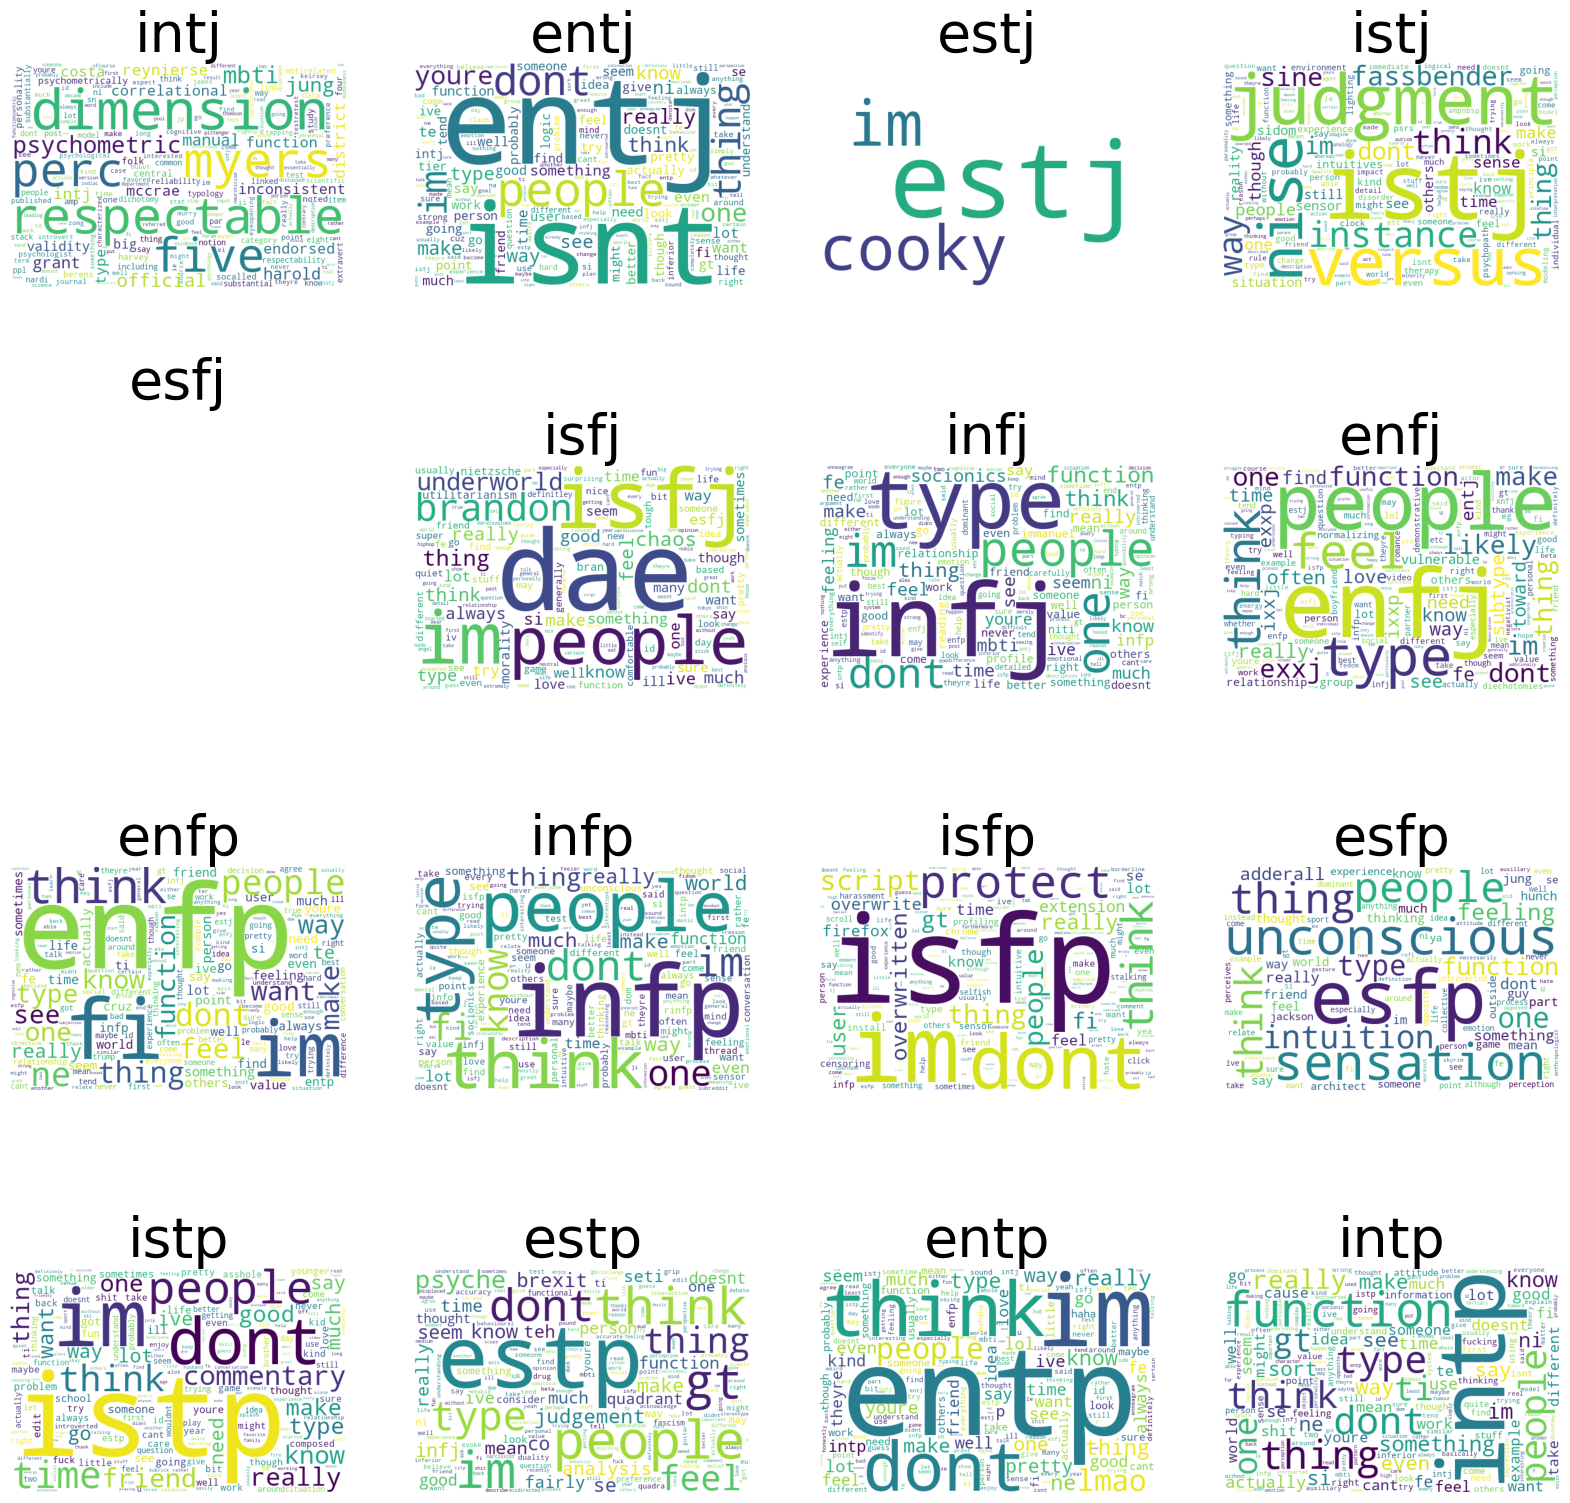

In [63]:
fig, ax = plt.subplots(4, 4, figsize=[20, 20])
for i in range(4):
    for j in range(4):
        if 4*i+j != 4:
            wordcloud = WordCloud(background_color='white', width=600, height=400,collocations=False).generate(data_for_wordcloud[4*i+j])
            ax[i,j].imshow(wordcloud)
        ax[i,j].axis('off')
        ax[i,j].set_title(flair_list[4*i+j],fontsize=40)
plt.show()

# Communities

In [204]:
G = G.to_undirected()
trials = 1000
number_of_communities = np.zeros(trials)
for i in range(trials):
    if i % 100 == 0:
        print(i)
    partition = community.best_partition(G)
    number_of_communities[i] = len(set(partition.values()))

med = int(np.median(number_of_communities))
# Print the number of communities
print("Mean number of communities:", np.mean(number_of_communities))
print("Median number of communities:", int(np.median(number_of_communities)))

0
100
200
300
400
500
600
700
800
900
Mean number of communities: 27.986
Median number of communities: 28


In [213]:
def modularity(G,partition):
    modularity_vals = []
    L = G.number_of_edges()
    for i in range(len(partition)):
        Lc = G.subgraph(partition[i]).number_of_edges()
        kc = 0
        for node in partition[i]:
            kc += G.degree(node)
        modularity_vals.append(Lc/L - (kc/(2*L))**2)
    return sum(modularity_vals)

while True:
    partition = community.best_partition(G)
    if len(set(partition.values())) == med:
        break

# Create dataframe with rapper name and community
df_community = pd.DataFrame(list(partition.items()),columns = ['Author','Community'])
df_community = df_community.sort_values(by='Community')

# modularity
print('Modularity:',modularity(G, [df_community[df_community['Community']==i]['Author'].values for i in range(len(df_community['Community'].unique()))]))

Modularity: 0.1942286565899849


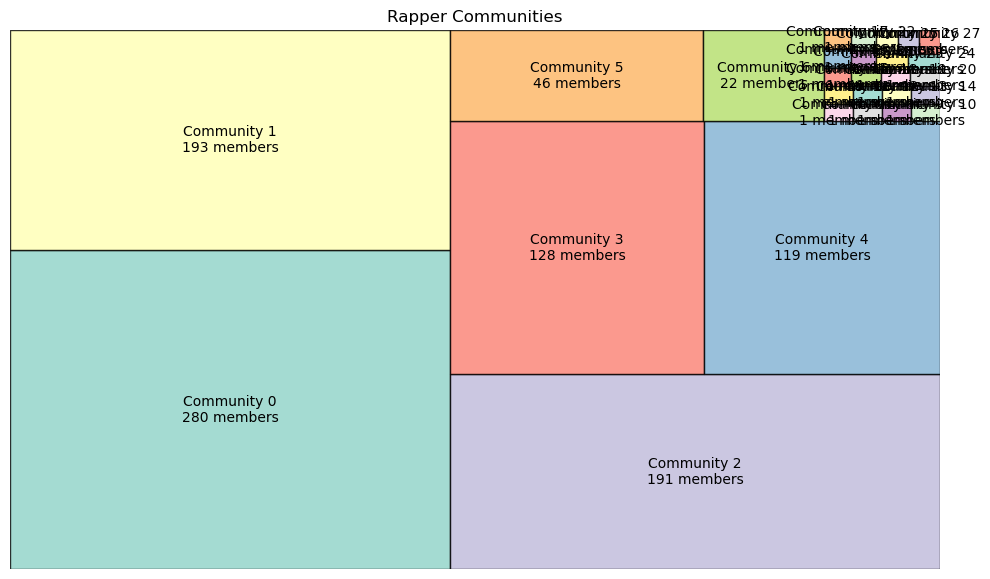

In [207]:
number_of_unique_communities = len(df_community['Community'].unique())
number_of_members_in_each_community = df_community['Community'].value_counts().values

labels = ['Community ' + str(i) + '\n' + str(number_of_members_in_each_community[i]) + ' members' for i in range(number_of_unique_communities)]
plt.figure(figsize=(12,7))
squarify.plot(sizes=df_community['Community'].value_counts().values,label=labels,alpha=.8,color=sb.color_palette("Set3", number_of_unique_communities),ec='black')
plt.title('Communities')
plt.axis('off')
plt.show()

,Author,Community
0,fatassj,0
201,Poropopper,0
32,AwesomeAsian,0
624,heliotach712,0
78,wcb98,0
...,...,...
486,yuzae,23
528,Xzcouter,24
568,Luzzifus,25
696,downloadeded,26


In [250]:
# find the authors from the graph in data
authors = list(G.nodes())
data = data[data['author'].isin(authors)]


1000